# PyTorch Model v3

## Creating a virtual environment for the project (Windows)

### Creating a virtual environment
The following command creates a virtual environment in the current directory.

The name of the virtual environment is .venv.

Remember to ensure that the kernel is set to the virtual environment.

```powershell
python -m venv .venv
```

### Activating the virtual environment
The following command activates the virtual environment.

```powershell
.\.venv\Scripts\Activate.ps1
```

### Deactivating the virtual environment
The following command deactivates the virtual environment.

```powershell
deactivate
```

### Installing packages
The following command installs the packages listed in requirements.txt.

```powershell
pip install -r requirements.txt
```

### Updating requirements.txt
The following command updates requirements.txt with the packages installed in the virtual environment.

```powershell
pip freeze > requirements.txt
```

### Appending additional index URL to requirements.txt

```
-i https://download.pytorch.org/whl/nightly/cu121
```

# Changes from v2
- Increased `image_dimensions` from `128` to `224`
- Added `weight_decay` of `0.005` to `optimizer`
- Replaced transformations with AutoAugment from PyTorch
- Calculate mean and standard deviation of dataset
- Also apply float normalization transformation. (Currently commented out until I can figure out why it warps colors)
- Added complex convolutional layers referencing VGG16.

# Imports

In [17]:
import math
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.autograd.profiler as profiler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.metrics import confusion_matrix
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchsummary import summary
from torchvision.io import read_image
from torchvision.transforms import AutoAugmentPolicy, v2
from tqdm import tqdm

# Global Variables

In [18]:
# Define the device to be used for training the model (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the path of the dataset
dataset_root_path = "./frames/"

# Define the folders of the dataset
dataset_folders = ["test", "train"]

# Define the categories of the dataset
classification_categories = ["norm", "weap"]  # 0 = norm, 1 = weap

# Define the path of the dataset
train_dir = os.path.join(dataset_root_path, "train")
test_dir = os.path.join(dataset_root_path, "test")

# Define the dimensions of the images
image_dimensions = (224, 224)

# Define batch size
batch_size = 16
grid_row_length = math.ceil(math.sqrt(batch_size))

# Define seed for reproducibility in train-validation split
seed = 42

# Define the number of epochs
epochs = 5

# Define model name
model_name = "pytorch_model_v3.pth"

# Printing Environment Information

In [19]:
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Device Count: ", torch.cuda.device_count())
print("Device: ", torch.cuda.get_device_name(0))
print("CUDA Available: ", torch.cuda.is_available())
print("Current CUDA Device Name: ",
      torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch Version:  2.2.0.dev20231101+cu121
Torchvision Version:  0.17.0.dev20231101+cu121
Device Count:  1
Device:  NVIDIA GeForce RTX 4090
CUDA Available:  True
Current CUDA Device Name:  NVIDIA GeForce RTX 4090


# Train on GPU if available

In [20]:
# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Reserved:', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

NVIDIA GeForce RTX 4090
Memory Usage:
Allocated: 1.5 GB
Reserved: 4.1 GB


# Label Creation

In [21]:
'''
This cell will attempt to create a csv file containing mappings of the image
file names along with a numerical label where 0 is norm and 1 is weap.
E.g.: "norm/0000_120.png,0"
E.g.: "weap/0200778_20220903_threat_8396_180.png,1"
'''

# Loop through the folders and categories
for folder in dataset_folders:
    temp_list = []
    for category in classification_categories:
        # Initialize an empty list to store the data

        # Loop through the images of the category
        image_dir = os.path.join(dataset_root_path, folder, category)
        for image in os.listdir(image_dir):
            # Append the image name and the category to the data list
            label = 0 if category == "norm" else 1
            temp_list.append((os.path.join(category, image), label))

    # Create a Pandas DataFrame from the data list
    df = pd.DataFrame(temp_list, columns=["image", "label"])

    # Save the DataFrame to a CSV file
    df.to_csv(f"{folder}_labels.csv", index=False)

# Custom DataLoader

In [22]:
'''
This cell will attempt to create a custom PyTorch dataset class that will
load the images and labels from the CSV file.
'''


class CustomImageDataset(Dataset):
    # https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_labels = str(self.img_labels.iloc[idx, 0])
        label = self.img_labels.iloc[idx, 1]

        img_path = os.path.join(self.img_dir, img_labels)
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Computing Mean and Standard Deviation for Normalization

In [23]:
mean = 0.0
std = 0.0
total_samples = 0

norm_transform = v2.Compose([
    v2.Resize(size=image_dimensions),
    v2.ToDtype(torch.float32, scale=True)
])
norm_dataset = CustomImageDataset("train_labels.csv", train_dir, transform=norm_transform)
norm_loader = DataLoader(norm_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

with tqdm(norm_loader, total=len(norm_loader), unit="batch", unit_scale=batch_size) as tepoch:
    for batch_idx, (image, label) in enumerate(tepoch, 0):
        batch_samples = image.size(0)
        image = image.view(batch_samples, image.size(1), -1)
        mean += image.mean(2).sum(0)
        std += image.std(2).sum(0)
        total_samples += batch_samples

mean /= total_samples
std /= total_samples

print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 3552/3552 [01:14<00:00, 47.58batch/s]

Mean: tensor([0.4602, 0.4406, 0.4161])
Std: tensor([0.2302, 0.2281, 0.2278])


# Defining Transforms

In [24]:
# Define a composition of image transformations
baseline_transforms = v2.Compose([
    # Resize the image to the required size
    v2.Resize(size=image_dimensions),
    # Convert the image to a tensor with pixels in the range [0, 1]
    v2.ToDtype(torch.float32, scale=True),
    # Normalize the image
    # v2.Normalize(mean=mean.tolist(), std=std.tolist()),
])

auto_augment_imagenet = v2.Compose([
    # Resize the image to the required size
    v2.Resize(size=image_dimensions),
    # Apply the AutoAugment policy
    v2.AutoAugment(AutoAugmentPolicy.IMAGENET),
    # Convert the image to a tensor with pixels in the range [0, 1]
    v2.ToDtype(torch.float32, scale=True),
    # Normalize the image
    # v2.Normalize(mean=mean.tolist(), std=std.tolist()),
])

auto_augment_cifar10 = v2.Compose([
    # Resize the image to the required size
    v2.Resize(size=image_dimensions),
    # Apply the AutoAugment policy
    v2.AutoAugment(AutoAugmentPolicy.CIFAR10),
    # Convert the image to a tensor with pixels in the range [0, 1]
    v2.ToDtype(torch.float32, scale=True),
    # Normalize the image
    # v2.Normalize(mean=mean.tolist(), std=std.tolist()),
])

auto_augment_svhn = v2.Compose([
    # Resize the image to the required size
    v2.Resize(size=image_dimensions),
    # Apply the AutoAugment policy
    v2.AutoAugment(AutoAugmentPolicy.SVHN),
    # Convert the image to a tensor with pixels in the range [0, 1]
    v2.ToDtype(torch.float32, scale=True),
    # Normalize the image
    # v2.Normalize(mean=mean.tolist(), std=std.tolist()),
])

# Applying Transforms

In [25]:
# Create the custom dataset
train_dataset = ConcatDataset([
    CustomImageDataset("train_labels.csv", train_dir,
                       transform=baseline_transforms),
    CustomImageDataset("train_labels.csv", train_dir,
                       transform=auto_augment_imagenet),
    CustomImageDataset("train_labels.csv", train_dir,
                       transform=auto_augment_cifar10),
    CustomImageDataset("train_labels.csv", train_dir,
                       transform=auto_augment_svhn)
])
test_dataset = ConcatDataset([
    CustomImageDataset("test_labels.csv", test_dir,
                       transform=baseline_transforms),
    CustomImageDataset("test_labels.csv", test_dir,
                       transform=auto_augment_imagenet),
    CustomImageDataset("test_labels.csv", test_dir,
                       transform=auto_augment_cifar10),
    CustomImageDataset("test_labels.csv", test_dir,
                       transform=auto_augment_svhn)
])

# Split the training dataset into training and validation datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(
    train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# Loading Custom Dataset

In [26]:
'''
pin_memory=True will automatically put the fetched data Tensors in pinned memory, 
and thus enables faster data transfer to CUDA-enabled GPUs.
'''

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Verifying Dataset

In [27]:
print("Train Dataset Size:", len(train_dataset))
print("Test Dataset Size:", len(test_dataset))
print("Total Dataset Size:", len(train_dataset) + len(test_dataset))

# Get a batch of training data (see batch_size above)
image, label = next(iter(train_dataloader))

print("Image Shape:", image.shape)  # (batch_size, channels, height, width)
print("Label Shape:", label.shape)  # Also can be inferred as batch_size

Train Dataset Size: 11318
Test Dataset Size: 8284
Total Dataset Size: 19602
Image Shape: torch.Size([16, 3, 224, 224])
Label Shape: torch.Size([16])


# Display Grid of Sample Train Images

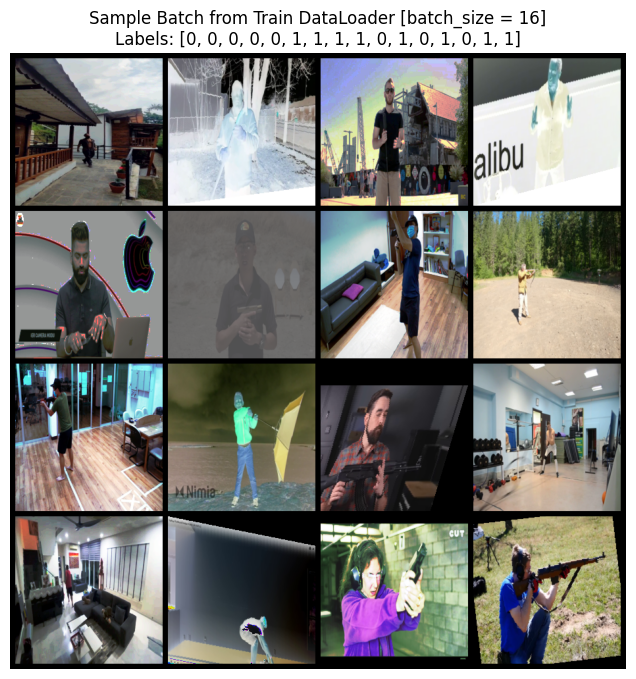

In [28]:
# Get a batch of training data (see batch_size above)
images, label = next(iter(train_dataloader))

# Make a grid from the sample batch
image_grid_sample = torchvision.utils.make_grid(
    images,
    nrow=grid_row_length,
    padding=8,
    normalize=False
)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(image_grid_sample.permute(1, 2, 0), vmin=0, vmax=1)
plt.title(
    f"Sample Batch from Train DataLoader [batch_size = {batch_size}]\nLabels: {label.tolist()}")
plt.axis("off")
plt.show()

# Defining the Neural Network

In [29]:
'''
Why don't I notice MASSIVE speedup compared to CPU? 
Because your network is really small.
Try increasing the width of your network 
E.g.: argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d
They need to be the same number, see what kind of speedup you get.

Calculate padding by using the formula:
padding = (kernel_size - 1) / stride
'''


class BaselineModel(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineModel, self).__init__()
        # https://pytorch.org/docs/main/nn.html#module-torch.nn
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        with profiler.record_function("model_inference"):
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.layer5(x)
            x = self.layer6(x)
            x = self.layer7(x)
            x = self.layer8(x)
            x = self.layer9(x)
            x = self.layer10(x)
            x = self.layer11(x)
            x = self.layer12(x)
            x = self.layer13(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
            x = self.fc1(x)
            x = self.fc2(x)
        return x


# Create an instance of the model
model = BaselineModel()

# Move the model to the GPU if available, must be called before creating optimizer
model = model.to(device)

# Verifying the Network

In [30]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Defining the Loss Function and Optimizer

In [31]:
# Define the loss function
# https://pytorch.org/docs/main/nn.html#loss-functions
criterion = nn.CrossEntropyLoss().to(device)

# Define the optimizer
'''
momentum is a parameter that helps accelerate gradients vectors in the right directions, thus leading to faster converging.
weight_decay is a regularization parameter that will reduce the magnitude of the weights, thus making the model more robust and prevent overfitting.
'''
optimizer = optim.SGD(model.parameters(), lr=0.005,
                      momentum=0.9, weight_decay=0.005)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validating the Model

In [32]:
'''
epoch is the number of times the model will loop through the entire dataset

batch_idx is the number of times the model will loop through the mini-batches

we zero the parameter gradients because PyTorch accumulates the gradients on
subsequent backward passes and we don't want to mix up gradients between mini-batches.

loss.backward() computes the derivative of the loss w.r.t. the parameters
using backpropagation. The loss is a function of the weights and biases of
the model that we initialized in the previous cell. The derivative is computed
for each parameter and stored in the .grad attribute of the parameter.

optimizer.step() updates the parameters using the gradients computed in the
previous step. Specifically, it subtracts a multiple of the gradient from the
parameter values. The multiple is controlled by the learning rate, which we
set to 0.001 in the previous cell.

train_train_train_train_train_running_loss is the sum of the losses of all the mini-batches in the current
epoch. We print the running loss every 25 mini-batches.

The loss is averaged over all examples in the mini-batch. For example, if the
batch size is 16, then the loss printed for each mini-batch is the average
loss of 16 examples in the mini-batch.
'''

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs): # loop over the dataset multiple times
  train_running_loss = 0.0
  train_correct = 0
  train_total = 0
  with tqdm(train_dataloader, total=len(train_dataloader), unit="batch", unit_scale=batch_size) as tepoch:
    for batch_idx, (image, label) in enumerate(tepoch, 0):
      tepoch.set_description(f"Training Epoch {epoch + 1}")

      # Move the data to the device that is used (GPU or CPU)
      image, label = image.to(device), label.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward Pass
      outputs = model(image)
      loss = criterion(outputs, label)

      # Backward Pass
      loss.backward()
      optimizer.step()

      train_running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      train_total += torch.numel(label)
      train_correct += predicted.eq(label).sum().item()

      tepoch.set_postfix(loss=train_running_loss / ((batch_idx + 1) * batch_size), accuracy=100. * train_correct / train_total)
    
    train_loss = train_running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_accuracy = 100. * train_correct / train_total
    train_accuracies.append(train_accuracy)
  
  with torch.no_grad():
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with tqdm(val_dataloader, total=len(val_dataloader), unit="batch", unit_scale=batch_size) as tepoch:
      for batch_idx, (image, label) in enumerate(tepoch, 0):
        tepoch.set_description(f"Validation Epoch {epoch + 1}")

        # Move the data to the device that is used (GPU or CPU)
        image, label = image.to(device), label.to(device)

        # Forward Pass
        outputs = model(image)
        loss = criterion(outputs, label)

        val_running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += torch.numel(label)
        val_correct += predicted.eq(label).sum().item()

        tepoch.set_postfix(loss=val_running_loss / ((batch_idx + 1) * batch_size), accuracy=100. * val_correct / val_total)
      
      val_loss = val_running_loss / len(val_dataloader)
      val_losses.append(val_loss)
      val_accuracy = 100. * val_correct / val_total
      val_accuracies.append(val_accuracy)

print("Finished Training and Validation")

Validation Epoch 5: 100%|██████████| 2832/2832 [01:08<00:00, 41.64batch/s, accuracy=58.9, loss=0.0423]

Finished Training and Validation


# Saving the Trained Model

In [33]:
# Save the model
torch.save(model.state_dict(), model_name)

# Plotting the Loss and Accuracy

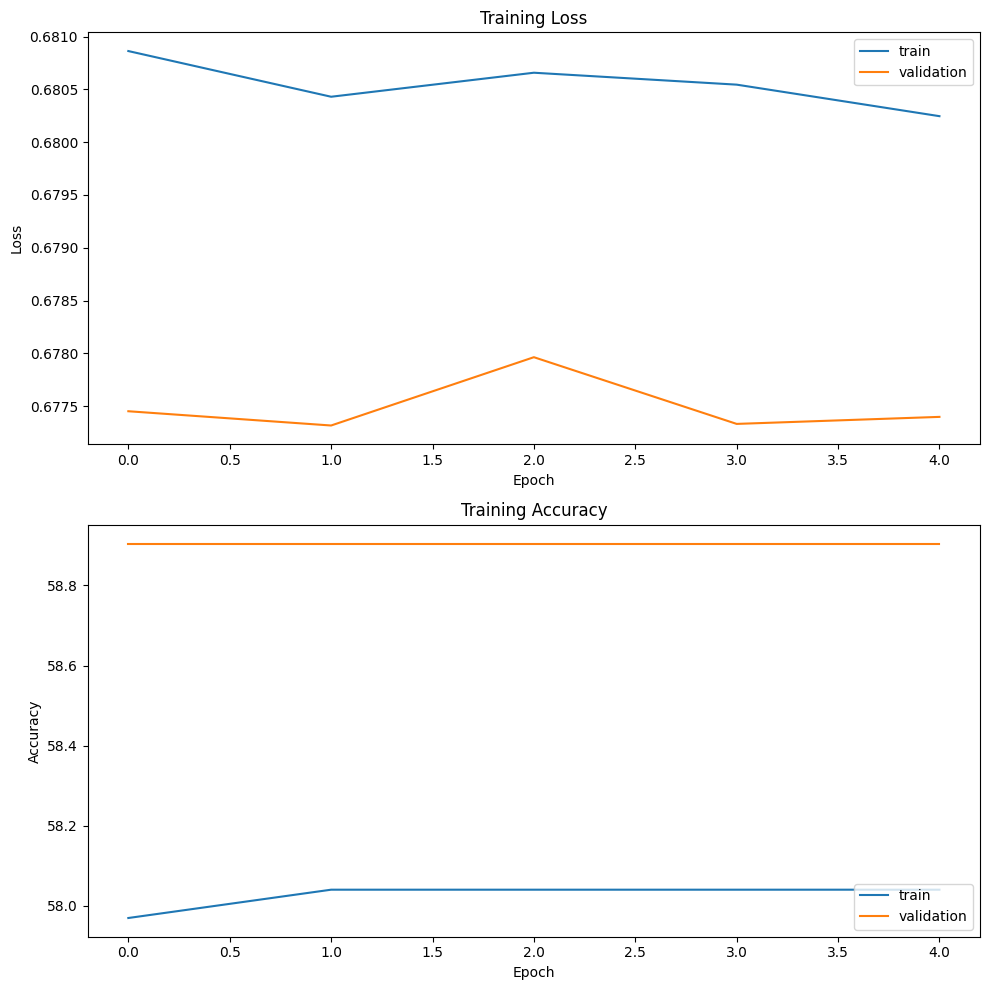

In [34]:
# Plot training loss and accuracy curves
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.legend(loc="upper right")

plt.subplot(2, 1, 2)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, label="train")
plt.plot(val_accuracies, label="validation")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Display Grid of Sample Test Images

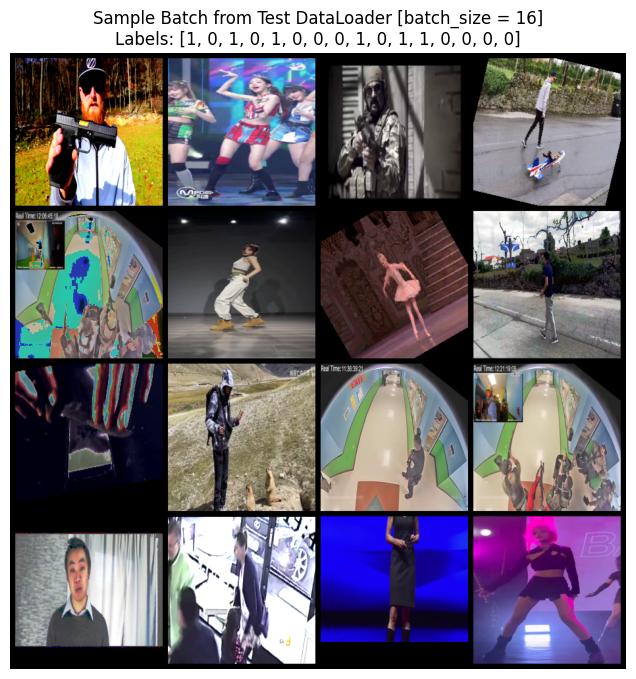

In [35]:
# Get a batch of test data (see batch_size above)
images, label = next(iter(test_dataloader))

# Make a grid from the sample batch
image_grid_sample = torchvision.utils.make_grid(
    images,
    nrow=grid_row_length,
    padding=8,
    normalize=False
)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(image_grid_sample.permute(1, 2, 0), vmin=0, vmax=1)
plt.title(
    f"Sample Batch from Test DataLoader [batch_size = {batch_size}]\nLabels: {label.tolist()}")
plt.axis("off")
plt.show()

# Testing the Model with Sample Test Images

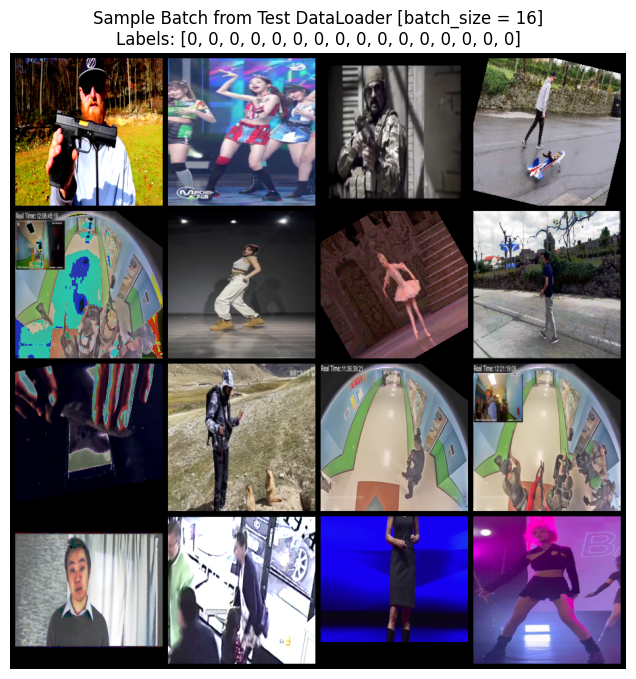

In [36]:
# Create an instance of the model
model = BaselineModel().to(device)

# Load the model
model.load_state_dict(torch.load(model_name))

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    outputs = model(images.to(device))  # Move and compute on GPU

_, predicted = torch.max(outputs, 1)

# Plot the grid with corresponding labels and predictions
plt.figure(figsize=(8, 8))
plt.imshow(image_grid_sample.permute(1, 2, 0), vmin=0, vmax=1)
plt.title(
    f"Sample Batch from Test DataLoader [batch_size = {batch_size}]\nLabels: {predicted.tolist()}")
plt.axis("off")
plt.show()

# Accuracy of the Model with Full Test Dataset

In [37]:
'''
TODO: Should we split the training set into a training and validation set?
Because it doesn't make sense for test set to have a loss and accuracy graph.
'''
test_losses = []
test_accuracies = []

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classification_categories}
total_pred = {classname: 0 for classname in classification_categories}

true_labels = []
predicted_labels = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  test_total = 0
  test_correct = 0
  with tqdm(test_dataloader, total=len(test_dataloader), unit="batch", unit_scale=batch_size) as tepoch:
    for batch_idx, (image, label) in enumerate(tepoch, 0):
      image, label = image.to(device), label.to(device)
      outputs = model(image)
      _, predicted = torch.max(outputs, 1)
      test_total += torch.numel(label)
      test_correct += predicted.eq(label).sum().item()

      tepoch.set_postfix(accuracy=100. * test_correct / test_total)

      # collect the correct predictions for each class
      for l, p in zip(label, predicted):
        if l == p:
          correct_pred[classification_categories[l]] += 1
        total_pred[classification_categories[l]] += 1

      true_labels.extend(label.tolist())
      predicted_labels.extend(predicted.tolist())

print(f'Accuracy of the network on the {len(test_dataset)} test images: {100 * test_correct / test_total}%')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

100%|██████████| 8288/8288 [02:59<00:00, 46.08batch/s, accuracy=62.4]

Accuracy of the network on the 8284 test images: 62.38532110091743%
Accuracy for class: norm  is 100.0 %
Accuracy for class: weap  is 0.0 %


# Plotting the Confusion Matrix

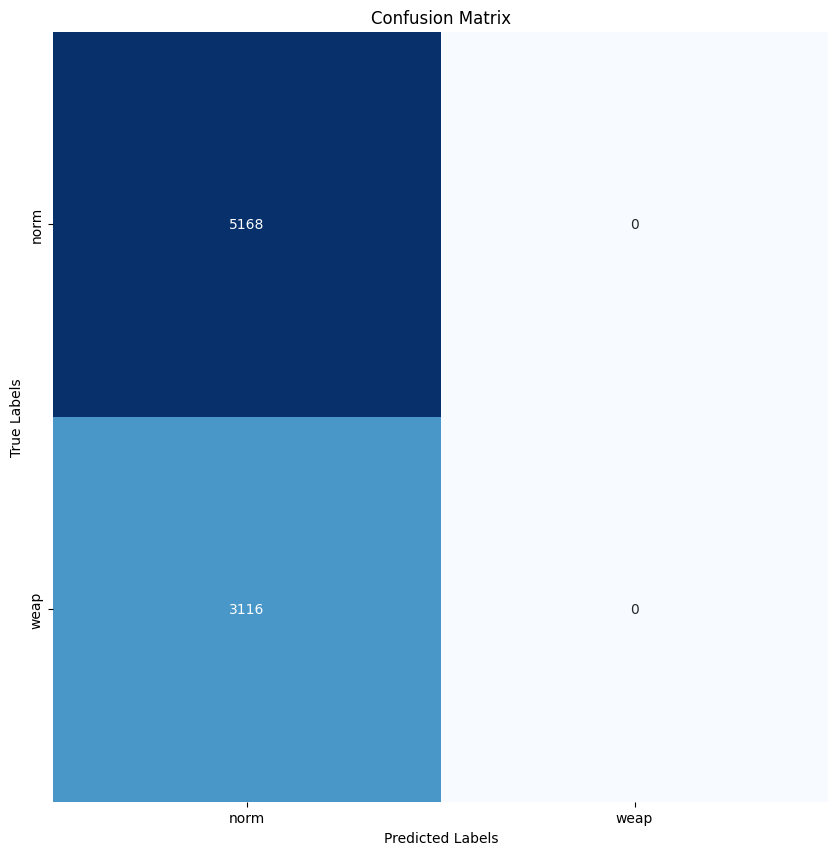

In [38]:
# Get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=classification_categories, columns=classification_categories)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [39]:
print(prof.key_averages(group_by_stack_n=5).table(
    sort_by='self_cpu_time_total', row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::copy_        70.80%       4.045ms        70.80%       4.045ms       4.045ms           0 b           0 b           0 b           0 b             1  
                  model_inference        10.47%     598.000us        28.44%       1.625ms       1.625ms           0 b           0 b       1.09 Gb    -830.00 Mb             1  
          aten::cudnn_convolution         7.12%     407.000us         7.12%     407.000us      31.308us           0 b  

In [40]:
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         aten::to         0.16%       9.000us        71.56%       4.088ms       4.088ms           0 b           0 b       9.19 Mb           0 b             1  
                   aten::_to_copy         0.30%      17.000us        71.40%       4.079ms       4.079ms           0 b           0 b       9.19 Mb           0 b             1  
              aten::empty_strided         0.30%      17.000us         0.30%      17.000us      17.000us           0 b  